In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import Counter
import datetime
import time
import os
import json
import librosa.display
import matplotlib.pyplot as plt

from src.data import NSynthDataset
from src.utils import print_and_log
from src.models import AutoencoderClassifier

/opt/conda/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
if torch.cuda.is_available():  
    device = torch.device("cuda:0")
else:  
    device = torch.device("cpu") 

In [3]:
hparams = {
    'checkpoint' : None,
    'feature_type' : 'mel',
    'instrument_source' : [0, 1, 2],
    'remove_synth_lead' : True,
    'scaling' : 'normalize',
    'resize' : (128, 128),
    'n_epochs' : 25,
    'batch_size' : 64,
    'lr' : 0.0001,
    'hidden_dim' : 512,
    'display_iters' : 100,
    'val_iters' : 1000,
    'n_val_samples' : 1000, 
    'n_early_stopping' : 5 # stop if validation doesn't improve after this number of validation cycles
}

In [4]:
train_dataset = NSynthDataset(
    'data/nsynth/nsynth-train', 
    instrument_source=hparams['instrument_source'], 
    feature_type=hparams['feature_type'],
    scaling=hparams['scaling'],
    resize=hparams['resize'],
    include_meta=True,
    remove_synth_lead=hparams['remove_synth_lead']
)

val_dataset = NSynthDataset(
    'data/nsynth/nsynth-valid', 
    instrument_source=hparams['instrument_source'], 
    feature_type=hparams['feature_type'],
    scaling=hparams['scaling'],
    resize=hparams['resize'],
    include_meta=True,
    remove_synth_lead=hparams['remove_synth_lead']
)

In [5]:
class_ctr = Counter([x['instrument_family_str'] for x in train_dataset.meta.values()])
class_dict = dict(enumerate(sorted(class_ctr)))
inv_class_dict = dict([(v, k) for k, v in class_dict.items()])
class_weights = np.array([max(class_ctr.values())/class_ctr[class_dict[i]] for i in range(len(class_dict))])

In [6]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams['batch_size'], shuffle=True)

In [7]:
model = AutoencoderClassifier(n_classes=len(class_dict), h_dim=hparams['hidden_dim']).to(device)
print('# of parameters : {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# of parameters : 8798987


In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=hparams['lr'])

In [9]:
timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d-%H%M%S')
results_dir = 'train_results/multitask/{}'.format(timestamp)
os.makedirs(results_dir)

with open(os.path.join(results_dir, 'hparams.json'), 'w') as fp:
    json.dump(hparams, fp)

log_file = os.path.join(results_dir, 'train_log.txt')
log = open(log_file, 'w')
log.close()
print_and_log('{}'.format(model.__class__.__name__), log_file)

for k, v in hparams.items(): print_and_log('{} : {}'.format(k, v), log_file)

AutoencoderClassifier


[0,     1] loss : (total - 3.4354, class - 2.4396, recon - 0.9959), acc : 0.0625
[0,   100] loss : (total - 2.1239, class - 1.5767, recon - 0.5471), acc : 0.3594
[0,   200] loss : (total - 2.1669, class - 1.7081, recon - 0.4588), acc : 0.3438
[0,   300] loss : (total - 1.9916, class - 1.6949, recon - 0.2967), acc : 0.3438
[0,   400] loss : (total - 1.3946, class - 1.1909, recon - 0.2037), acc : 0.5312
[0,   500] loss : (total - 1.3030, class - 1.1472, recon - 0.1558), acc : 0.4844
[0,   600] loss : (total - 1.4043, class - 1.2838, recon - 0.1206), acc : 0.5156
[0,   700] loss : (total - 1.6267, class - 1.5290, recon - 0.0977), acc : 0.4375
[0,   800] loss : (total - 1.2410, class - 1.1645, recon - 0.0765), acc : 0.5469
[0,   900] loss : (total - 1.4015, class - 1.3378, recon - 0.0637), acc : 0.5156
[0,  1000] loss : (total - 1.1034, class - 1.0492, recon - 0.0541), acc : 0.5156
Val - loss : (total - 3.2592, class - 3.2021, recon - 0.0572), acc : 0.2012


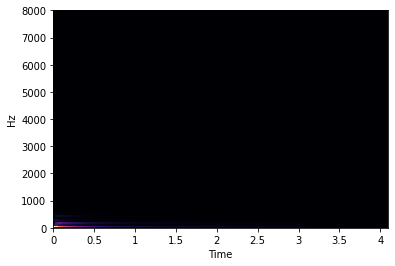

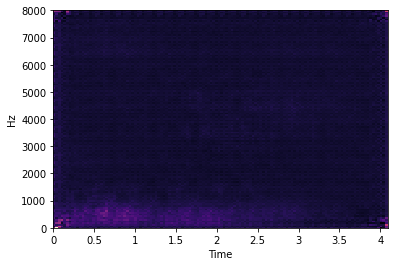

Weights saved in train_results/multitask/20200603-173028/model-1000.weights
[0,  1100] loss : (total - 1.2273, class - 1.1803, recon - 0.0470), acc : 0.5469
[0,  1200] loss : (total - 0.8556, class - 0.8100, recon - 0.0456), acc : 0.6406
[0,  1300] loss : (total - 1.0400, class - 1.0046, recon - 0.0354), acc : 0.6406
[0,  1400] loss : (total - 0.9244, class - 0.8915, recon - 0.0329), acc : 0.6406
[0,  1500] loss : (total - 0.9051, class - 0.8763, recon - 0.0288), acc : 0.6250
[0,  1600] loss : (total - 0.9346, class - 0.9055, recon - 0.0291), acc : 0.6875
[0,  1700] loss : (total - 0.8480, class - 0.8183, recon - 0.0297), acc : 0.6094
[0,  1800] loss : (total - 0.6987, class - 0.6729, recon - 0.0259), acc : 0.7031
[0,  1900] loss : (total - 0.8449, class - 0.8208, recon - 0.0241), acc : 0.6094
[0,  2000] loss : (total - 0.7162, class - 0.6933, recon - 0.0229), acc : 0.6875
Val - loss : (total - 3.0087, class - 2.9832, recon - 0.0255), acc : 0.2627


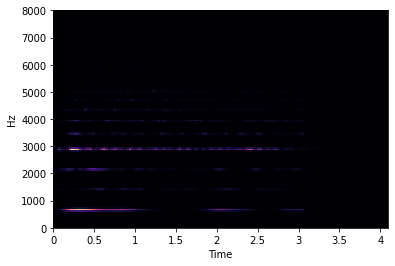

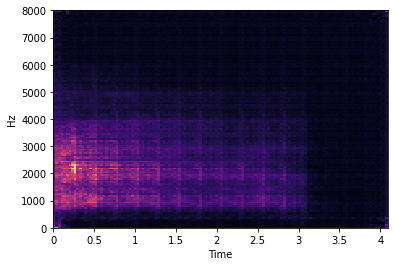

Weights saved in train_results/multitask/20200603-173028/model-2000.weights
[0,  2100] loss : (total - 0.5402, class - 0.5188, recon - 0.0214), acc : 0.8438
[0,  2200] loss : (total - 0.8633, class - 0.8410, recon - 0.0224), acc : 0.7188
[0,  2300] loss : (total - 0.6734, class - 0.6509, recon - 0.0226), acc : 0.6875
[0,  2400] loss : (total - 0.5968, class - 0.5783, recon - 0.0185), acc : 0.7344
[0,  2500] loss : (total - 0.9192, class - 0.8953, recon - 0.0238), acc : 0.7344
[0,  2600] loss : (total - 0.6126, class - 0.5922, recon - 0.0204), acc : 0.7969
[0,  2700] loss : (total - 0.6757, class - 0.6592, recon - 0.0166), acc : 0.7344
[0,  2800] loss : (total - 0.6919, class - 0.6734, recon - 0.0185), acc : 0.7188
[0,  2900] loss : (total - 0.5656, class - 0.5429, recon - 0.0227), acc : 0.7500
[0,  3000] loss : (total - 0.5990, class - 0.5835, recon - 0.0155), acc : 0.7500
Val - loss : (total - 1.9109, class - 1.8910, recon - 0.0199), acc : 0.4258


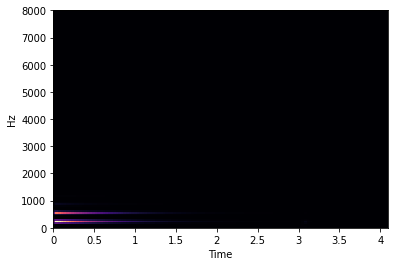

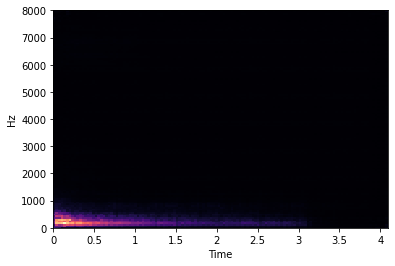

Weights saved in train_results/multitask/20200603-173028/model-3000.weights
[0,  3100] loss : (total - 0.3302, class - 0.3122, recon - 0.0180), acc : 0.8438
[0,  3200] loss : (total - 0.5498, class - 0.5289, recon - 0.0209), acc : 0.7344
[0,  3300] loss : (total - 0.7107, class - 0.6955, recon - 0.0151), acc : 0.7500
[0,  3400] loss : (total - 0.4228, class - 0.4033, recon - 0.0195), acc : 0.8125
[0,  3500] loss : (total - 0.3779, class - 0.3581, recon - 0.0198), acc : 0.8281
[0,  3600] loss : (total - 0.3762, class - 0.3573, recon - 0.0189), acc : 0.8594
[0,  3700] loss : (total - 0.4138, class - 0.3954, recon - 0.0184), acc : 0.8125
[0,  3800] loss : (total - 0.2340, class - 0.2163, recon - 0.0177), acc : 0.9219
[0,  3900] loss : (total - 0.3892, class - 0.3743, recon - 0.0149), acc : 0.9062
[0,  4000] loss : (total - 0.2786, class - 0.2616, recon - 0.0170), acc : 0.8750
Val - loss : (total - 6.7620, class - 6.7298, recon - 0.0322), acc : 0.1719


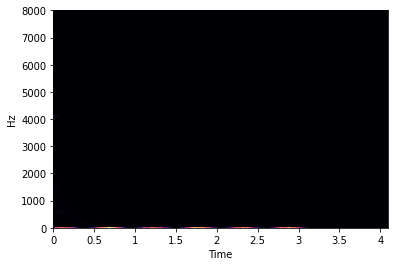

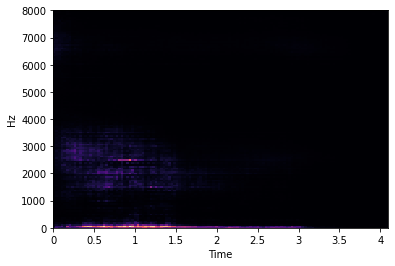

[0,  4100] loss : (total - 0.5869, class - 0.5699, recon - 0.0169), acc : 0.7188
[0,  4200] loss : (total - 0.3340, class - 0.3160, recon - 0.0180), acc : 0.8438
[0,  4300] loss : (total - 0.2653, class - 0.2488, recon - 0.0165), acc : 0.9219
[0,  4400] loss : (total - 0.3990, class - 0.3819, recon - 0.0172), acc : 0.8906
[1,  4500] loss : (total - 0.2957, class - 0.2797, recon - 0.0160), acc : 0.8438
[1,  4600] loss : (total - 0.3096, class - 0.2929, recon - 0.0167), acc : 0.8906
[1,  4700] loss : (total - 0.3563, class - 0.3403, recon - 0.0160), acc : 0.8906
[1,  4800] loss : (total - 0.2339, class - 0.2176, recon - 0.0163), acc : 0.8906
[1,  4900] loss : (total - 0.3303, class - 0.3141, recon - 0.0162), acc : 0.8906
[1,  5000] loss : (total - 0.3289, class - 0.3134, recon - 0.0155), acc : 0.8906
Val - loss : (total - 2.7998, class - 2.7778, recon - 0.0220), acc : 0.3242


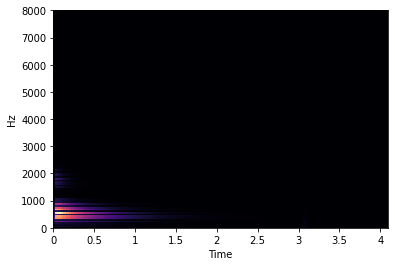

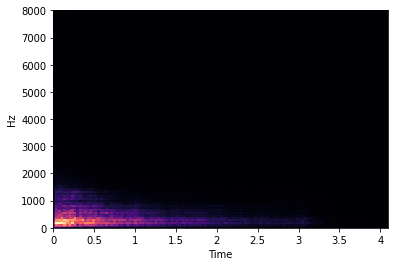

[1,  5100] loss : (total - 0.2572, class - 0.2401, recon - 0.0171), acc : 0.9062
[1,  5200] loss : (total - 0.3381, class - 0.3259, recon - 0.0122), acc : 0.8281
[1,  5300] loss : (total - 0.2088, class - 0.1935, recon - 0.0154), acc : 0.9375
[1,  5400] loss : (total - 0.2855, class - 0.2687, recon - 0.0168), acc : 0.8594
[1,  5500] loss : (total - 0.1838, class - 0.1705, recon - 0.0133), acc : 0.9062
[1,  5600] loss : (total - 0.2044, class - 0.1871, recon - 0.0172), acc : 0.9219
[1,  5700] loss : (total - 0.2578, class - 0.2401, recon - 0.0177), acc : 0.8750
[1,  5800] loss : (total - 0.2225, class - 0.2056, recon - 0.0169), acc : 0.9219
[1,  5900] loss : (total - 0.2551, class - 0.2369, recon - 0.0182), acc : 0.8750
[1,  6000] loss : (total - 0.3391, class - 0.3190, recon - 0.0201), acc : 0.9062
Val - loss : (total - 2.8974, class - 2.8771, recon - 0.0203), acc : 0.3799


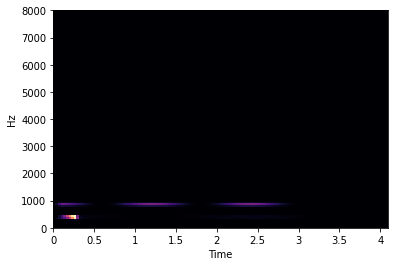

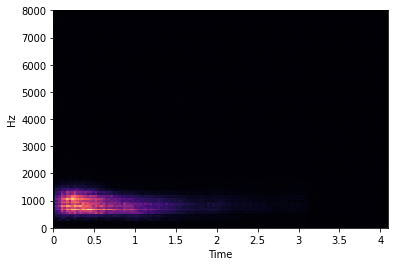

[1,  6100] loss : (total - 0.4972, class - 0.4790, recon - 0.0183), acc : 0.7969
[1,  6200] loss : (total - 0.2776, class - 0.2624, recon - 0.0152), acc : 0.8594
[1,  6300] loss : (total - 0.1164, class - 0.1013, recon - 0.0150), acc : 0.9688
[1,  6400] loss : (total - 0.2070, class - 0.1936, recon - 0.0134), acc : 0.9219
[1,  6500] loss : (total - 0.3225, class - 0.3077, recon - 0.0148), acc : 0.8750
[1,  6600] loss : (total - 0.1522, class - 0.1343, recon - 0.0179), acc : 0.9062
[1,  6700] loss : (total - 0.3062, class - 0.2928, recon - 0.0134), acc : 0.8281
[1,  6800] loss : (total - 0.3988, class - 0.3866, recon - 0.0122), acc : 0.8594
[1,  6900] loss : (total - 0.2921, class - 0.2795, recon - 0.0126), acc : 0.9531
[1,  7000] loss : (total - 0.3028, class - 0.2846, recon - 0.0181), acc : 0.8281
Val - loss : (total - 1.9801, class - 1.9612, recon - 0.0189), acc : 0.4678


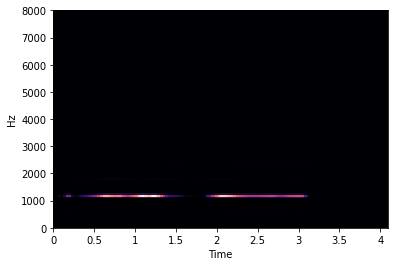

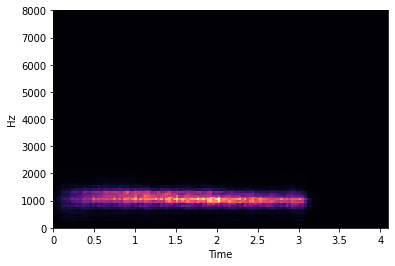

[1,  7100] loss : (total - 0.1708, class - 0.1536, recon - 0.0172), acc : 0.9531
[1,  7200] loss : (total - 0.3319, class - 0.3156, recon - 0.0162), acc : 0.8594
[1,  7300] loss : (total - 0.2625, class - 0.2463, recon - 0.0162), acc : 0.8750
[1,  7400] loss : (total - 0.1960, class - 0.1809, recon - 0.0151), acc : 0.9531
[1,  7500] loss : (total - 0.3182, class - 0.3034, recon - 0.0147), acc : 0.8906
[1,  7600] loss : (total - 0.1808, class - 0.1664, recon - 0.0144), acc : 0.8594
[1,  7700] loss : (total - 0.2898, class - 0.2736, recon - 0.0162), acc : 0.9062
[1,  7800] loss : (total - 0.1680, class - 0.1531, recon - 0.0148), acc : 0.9531
[1,  7900] loss : (total - 0.1254, class - 0.1057, recon - 0.0198), acc : 0.9688
[1,  8000] loss : (total - 0.1334, class - 0.1198, recon - 0.0136), acc : 0.9531
Val - loss : (total - 2.7997, class - 2.7743, recon - 0.0253), acc : 0.3184


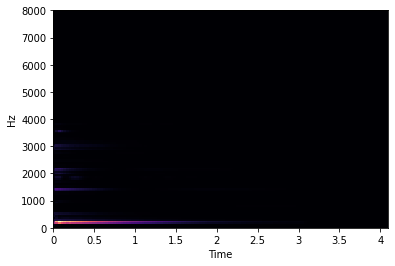

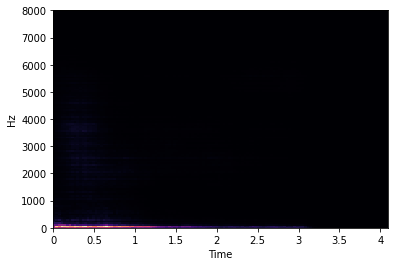

Early stopping... training complete


In [10]:
recon_loss_fn = nn.BCELoss()
class_loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32, device=device))

ckpt_weights_path = None
best_loss = 1e10
since_best = 0
done = False

if hparams['checkpoint']:
    print_and_log('Resuming training from {}'.format(hparams['checkpoint']), log_file)
    ckpt = torch.load(hparams['checkpoint'])
    epoch = ckpt['epoch']
    itr = ckpt['itr']
    optimizer.load_state_dict(ckpt['optimizer'])
    model.load_state_dict(ckpt['model'])
    best_loss = ckpt['best_loss']
else:
    epoch = 0
    itr = 0

for epoch in range(epoch, hparams['n_epochs']):
    if done:
        break
        
    for batch in train_dataloader:
        if done:
            break
            
        itr += 1
        features = batch[0].unsqueeze(1).to(device)
        labels = torch.tensor([inv_class_dict[i] for i in batch[1]['instrument_family_str']], 
                              dtype=torch.long, device=device)
        logits, recon = model(features)
        
        class_loss = class_loss_fn(logits, labels)
        recon_loss = recon_loss_fn(recon, features)
        loss = class_loss + recon_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (itr % hparams['display_iters'] == 0) or (itr == 1):
            acc = (logits.argmax(-1) == labels).float().mean()
            print_and_log('[{}, {:5d}] loss : (total - {:.4f}, class - {:.4f}, recon - {:.4f}), acc : {:.4f}'\
                          .format(epoch, itr, loss.item(), class_loss.item(), recon_loss.item(), acc.item()), log_file)
            
        if itr % hparams['val_iters'] == 0:
            val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams['batch_size'], shuffle=True)
            
            model.eval()
            
            with torch.no_grad():
                ct, i, val_loss, val_class_loss, val_recon_loss, val_acc = 0, 0, 0.0, 0.0, 0.0, 0.0
                for batch in val_dataloader:
                    i += 1
                    ct += batch[0].size(0)
                    features = batch[0].unsqueeze(1).to(device)
                    labels = torch.tensor([inv_class_dict[i] for i in batch[1]['instrument_family_str']], 
                                          dtype=torch.long, device=device)
                    logits, recon = model(features)

                    class_loss = class_loss_fn(logits, labels)
                    recon_loss = recon_loss_fn(recon, features)
                    loss = class_loss + recon_loss
                    acc = (logits.argmax(-1) == labels).float().mean()

                    val_loss += (loss.item() - val_loss)/i
                    val_class_loss += (class_loss.item() - val_class_loss)/i
                    val_recon_loss += (recon_loss.item() - val_recon_loss)/i
                    val_acc += (acc.item() - val_acc)/i

                    if ct >= hparams['n_val_samples']:
                        break
                
            print_and_log('Val - loss : (total - {:.4f}, class - {:.4f}, recon - {:.4f}), acc : {:.4f}'\
                          .format(val_loss, val_class_loss, val_recon_loss, val_acc), log_file)
            
            librosa.display.specshow(features[0][0].cpu().numpy(), sr=16000, x_axis='time', y_axis='hz')
            plt.show()
            librosa.display.specshow(recon[0][0].detach().cpu().numpy(), sr=16000, x_axis='time', y_axis='hz')
            plt.show()
            
            if val_loss < best_loss:
                since_best = 0
                best_loss = val_loss
                
                # save weights
                if ckpt_weights_path:
                    os.remove(ckpt_weights_path)
                ckpt_weights_path = os.path.join(results_dir, 'model-{}.weights'.format(itr))
                torch.save(model.state_dict(), ckpt_weights_path)
                print_and_log('Weights saved in {}'.format(ckpt_weights_path), log_file)
                
                # save meta information
                ckpt_meta_path = os.path.join(results_dir, 'checkpoint')
                torch.save({
                    'best_loss' : best_loss,
                    'epoch' : epoch,
                    'itr' : itr,
                    'optimizer' : optimizer.state_dict(),
                    'model' : model.state_dict()
                }, ckpt_meta_path)
            else:
                since_best += 1
                if since_best >= hparams['n_early_stopping']:
                    done = True
                    print_and_log('Early stopping... training complete', log_file)
            
            model.train()